In [10]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
pd.__version__

'2.2.3'

In [12]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops/mod-3/experiment_tracking/mlruns/2', creation_time=1742921486543, experiment_id='2', last_update_time=1742921486543, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [13]:
import pickle
import mlflow
import mlflow.xgboost

# Downloading the data

In [14]:
df = pd.read_parquet('/workspaces/mlops/mod-3/experiment_tracking/data/green_tripdata_2021-01.parquet')
df.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [15]:
len(df.columns)

20

# Computing the duration

In [16]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df.duration.dt.total_seconds()/60

In [17]:
std_duration = df['duration'].std()
std_duration

np.float64(59.33859413164492)

# Dropping Outliers


In [18]:
df['duration'].min()

np.float64(0.0)

In [19]:
df['duration'].max()

np.float64(1439.6)

In [20]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100 ## ~2% outliers

96.58903787344154

In [21]:
df = df[(df.duration>=1) & (df.duration<=60)].copy()

# One Hot Encoding

In [22]:
categorical = ['PULocationID', 'DOLocationID']

In [23]:
df[categorical] = df[categorical].astype(str)

In [24]:
train_dicts = df[categorical].to_dict(orient='records')

In [25]:
train_dicts

[{'PULocationID': '43', 'DOLocationID': '151'},
 {'PULocationID': '166', 'DOLocationID': '239'},
 {'PULocationID': '41', 'DOLocationID': '42'},
 {'PULocationID': '168', 'DOLocationID': '75'},
 {'PULocationID': '75', 'DOLocationID': '75'},
 {'PULocationID': '225', 'DOLocationID': '265'},
 {'PULocationID': '244', 'DOLocationID': '244'},
 {'PULocationID': '75', 'DOLocationID': '213'},
 {'PULocationID': '74', 'DOLocationID': '238'},
 {'PULocationID': '74', 'DOLocationID': '60'},
 {'PULocationID': '42', 'DOLocationID': '41'},
 {'PULocationID': '74', 'DOLocationID': '116'},
 {'PULocationID': '116', 'DOLocationID': '143'},
 {'PULocationID': '75', 'DOLocationID': '42'},
 {'PULocationID': '74', 'DOLocationID': '75'},
 {'PULocationID': '7', 'DOLocationID': '82'},
 {'PULocationID': '152', 'DOLocationID': '117'},
 {'PULocationID': '116', 'DOLocationID': '74'},
 {'PULocationID': '116', 'DOLocationID': '69'},
 {'PULocationID': '259', 'DOLocationID': '116'},
 {'PULocationID': '247', 'DOLocationID': '

In [26]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [27]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [28]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (73908, 506)


# Training a model

In [29]:
target = 'duration'
y_train = df[target].values

In [30]:
X_train[2,1], y_train[2]

(np.float64(0.0), np.float64(5.966666666666667))

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Training RMSE: {mean_squared_error(y_train, y_pred)}')

Training RMSE: 95.56227794262217


In [32]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

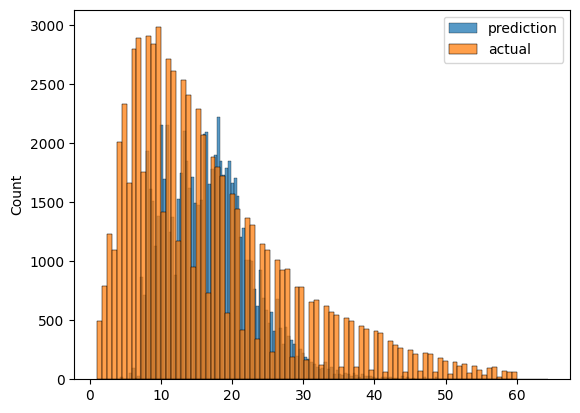

In [33]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')
plt.legend()

# Evaluating the model

In [34]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [35]:
df_val = read_data('/workspaces/mlops/mod-3/experiment_tracking/data/green_tripdata_2021-02.parquet')

In [36]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [37]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [38]:
y_pred = lr.predict(X_val)

In [39]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred)}')

Val RMSE: 109.69915267296534


In [40]:
with mlflow.start_run():
    mlflow.set_tag("developer","komali")
    mlflow.log_param("train-data-path","data/green_tripdata_2021-01.parquet")
    mlflow.log_param("test-data-path","data/green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

In [41]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'sqlite:///mlflow.db'


In [42]:
mlflow.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops/mod-3/experiment_tracking/mlruns/3', creation_time=1742929763269, experiment_id='3', last_update_time=1742929763269, lifecycle_stage='active', name='search-run-guide', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops/mod-3/experiment_tracking/mlruns/2', creation_time=1742921486543, experiment_id='2', last_update_time=1742921486543, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops/mod-3/experiment_tracking/mlruns/0', creation_time=1742917390875, experiment_id='0', last_update_time=1742917390875, lifecycle_stage='active', name='Default', tags={}>]

In [43]:
import xgboost as xgb

In [44]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [40]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:11.74736                                                                                                                                                  
[1]	validation-rmse:11.35534                                                                                                                                                  
[2]	validation-rmse:10.99460                                                                                                                                                  
[3]	validation-rmse:10.71494                                                                                                                                                  
  0%|                                                                                                                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:49:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:10.44597                                                                                                                                                  
[5]	validation-rmse:10.20433                                                                                                                                                  
[6]	validation-rmse:10.04426                                                                                                                                                  
[7]	validation-rmse:9.86661                                                                                                                                                   
[8]	validation-rmse:9.74408                                                                                                                                                   
[9]	validation-rmse:9.61602                                                                                                  

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:49:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:10.81116                                                                                                                                                  
[6]	validation-rmse:10.66587                                                                                                                                                  
[7]	validation-rmse:10.51767                                                                                                                                                  
[8]	validation-rmse:10.38540                                                                                                                                                  
[9]	validation-rmse:10.28670                                                                                                                                                  
[10]	validation-rmse:10.18093                                                                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:50:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:9.60783                                                                                                                                                   
[5]	validation-rmse:9.31624                                                                                                                                                   
[6]	validation-rmse:9.21018                                                                                                                                                   
[7]	validation-rmse:9.12984                                                                                                                                                   
[8]	validation-rmse:8.92101                                                                                                                                                   
[9]	validation-rmse:8.85893                                                                                                  

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:51:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.98061                                                                                                                                                   
[4]	validation-rmse:8.78703                                                                                                                                                   
[5]	validation-rmse:8.47465                                                                                                                                                   
[6]	validation-rmse:8.33412                                                                                                                                                   
[7]	validation-rmse:8.15541                                                                                                                                                   
[8]	validation-rmse:8.05766                                                                                                  

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:52:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.50301                                                                                                                                                  
[2]	validation-rmse:11.20007                                                                                                                                                  
[3]	validation-rmse:10.93170                                                                                                                                                  
[4]	validation-rmse:10.67457                                                                                                                                                  
[5]	validation-rmse:10.46809                                                                                                                                                  
[6]	validation-rmse:10.25717                                                                                                 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:52:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.47267                                                                                                                                                   
[4]	validation-rmse:9.16575                                                                                                                                                   
[5]	validation-rmse:9.05324                                                                                                                                                   
[6]	validation-rmse:8.91939                                                                                                                                                   
[7]	validation-rmse:8.63780                                                                                                                                                   
[8]	validation-rmse:8.55030                                                                                                  

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:53:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:8.83389                                                                                                                                                   
[6]	validation-rmse:8.76390                                                                                                                                                   
[7]	validation-rmse:8.71084                                                                                                                                                   
[8]	validation-rmse:8.65225                                                                                                                                                   
[9]	validation-rmse:8.60956                                                                                                                                                   
[10]	validation-rmse:8.54991                                                                                                 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:54:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:9.95619                                                                                                                                                  
[11]	validation-rmse:9.91779                                                                                                                                                  
[12]	validation-rmse:9.86968                                                                                                                                                  
[13]	validation-rmse:9.82930                                                                                                                                                  
[14]	validation-rmse:9.80307                                                                                                                                                  
[15]	validation-rmse:9.75681                                                                                                 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:54:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:8.60739                                                                                                                                                  
[11]	validation-rmse:8.55054                                                                                                                                                  
[12]	validation-rmse:8.49491                                                                                                                                                  
[13]	validation-rmse:8.38290                                                                                                                                                  
[14]	validation-rmse:8.21919                                                                                                                                                  
[15]	validation-rmse:8.12620                                                                                                 

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:54:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.34445                                                                                                                                                  
[4]	validation-rmse:10.09512                                                                                                                                                  
[5]	validation-rmse:9.84611                                                                                                                                                   
[6]	validation-rmse:9.64927                                                                                                                                                   
[7]	validation-rmse:9.52237                                                                                                                                                   
[8]	validation-rmse:9.40073                                                                                                  

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:55:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:10.47428                                                                                                                                                 
[11]	validation-rmse:10.37821                                                                                                                                                 
[12]	validation-rmse:10.32765                                                                                                                                                 
[13]	validation-rmse:10.25357                                                                                                                                                 
[14]	validation-rmse:10.17591                                                                                                                                                 
[15]	validation-rmse:10.13709                                                                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:55:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:8.69441                                                                                                                                                   
[7]	validation-rmse:8.58056                                                                                                                                                   
[8]	validation-rmse:8.51158                                                                                                                                                   
[9]	validation-rmse:8.41027                                                                                                                                                   
[10]	validation-rmse:8.33680                                                                                                                                                  
[11]	validation-rmse:8.21113                                                                                                 

In [45]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.24190492799330687,
        'max_depth': 99,
        'min_child_weight': 19.921014700138183,
        'objective': 'reg:linear',
        'reg_alpha': 0.006753448240970355,
        'reg_lambda': 0.12994888010106037,
        'seed': 42
    }
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)





    

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:11.21112
[1]	validation-rmse:10.59542
[2]	validation-rmse:10.16364
[3]	validation-rmse:9.91596
[4]	validation-rmse:9.65281
[5]	validation-rmse:9.52700


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[6]	validation-rmse:9.42236
[7]	validation-rmse:9.28519
[8]	validation-rmse:9.22614
[9]	validation-rmse:9.17053
[10]	validation-rmse:9.08973
[11]	validation-rmse:9.05813
[12]	validation-rmse:9.01084
[13]	validation-rmse:8.97937
[14]	validation-rmse:8.95143
[15]	validation-rmse:8.92331
[16]	validation-rmse:8.90013
[17]	validation-rmse:8.87895
[18]	validation-rmse:8.85180
[19]	validation-rmse:8.83303
[20]	validation-rmse:8.81523
[21]	validation-rmse:8.79313
[22]	validation-rmse:8.76791
[23]	validation-rmse:8.75116
[24]	validation-rmse:8.73285
[25]	validation-rmse:8.71205
[26]	validation-rmse:8.69221
[27]	validation-rmse:8.67850
[28]	validation-rmse:8.65775
[29]	validation-rmse:8.63759
[30]	validation-rmse:8.61609
[31]	validation-rmse:8.59824
[32]	validation-rmse:8.58011
[33]	validation-rmse:8.56526
[34]	validation-rmse:8.54905
[35]	validation-rmse:8.53354
[36]	validation-rmse:8.51968
[37]	validation-rmse:8.50226
[38]	validation-rmse:8.48797
[39]	validation-rmse:8.47282
[40]	validation-rm

2025/03/26 19:19:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:19:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/26 19:19:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [39]:
import subprocess

subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

[2025-03-26 18:47:20 +0000] [3110] [INFO] Starting gunicorn 23.0.0
[2025-03-26 18:47:20 +0000] [3110] [INFO] Listening at: http://127.0.0.1:5000 (3110)
[2025-03-26 18:47:20 +0000] [3110] [INFO] Using worker: sync
[2025-03-26 18:47:20 +0000] [3111] [INFO] Booting worker with pid: 3111
[2025-03-26 18:47:20 +0000] [3112] [INFO] Booting worker with pid: 3112
[2025-03-26 18:47:20 +0000] [3113] [INFO] Booting worker with pid: 3113
[2025-03-26 18:47:20 +0000] [3114] [INFO] Booting worker with pid: 3114
